In [1]:
#Import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import scipy.stats as stats
from scipy.optimize import curve_fit


In [2]:
# Reading cleaned csv file
stroke_df = pd.read_csv("Resources/healthcare-dataset-stroke-data-cleaned.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,31.735817,never smoked,1
2,31112,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,1,Private,Urban,83.75,33.905702,never smoked,0
5106,44873,Female,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,1,Private,Rural,166.29,25.600000,formerly smoked,0


## Statistical analysis of age vs stroke dataset

In [3]:
# Group the ages in bins Where: 12 and younger is a children, 17 and younger is a Teenagers, 65 and younger is an Adults, and the rest is an Seniors 
age_groups = pd.cut(stroke_df['age'], bins=[0, 12, 17, 65, float('inf')], labels=['Children', 'Teenagers', 'Adults', 'Seniors'])

# Add the age group column to the DataFrame
stroke_df['age_group'] = age_groups

# Calculate the count of strokes in each age group
age_group_counts = stroke_df['age_group'].value_counts()

print(f"The distribution of ages is as follows:\n{age_group_counts}")

The distribution of ages is as follows:
Adults       3289
Seniors       965
Children      588
Teenagers     268
Name: age_group, dtype: int64


In [4]:

# Calculate the sum of strokes for each age group
age_group_sum = stroke_df.groupby('age_group')['stroke'].sum()

print(f"The distribution of strokes is as follows:\n{age_group_sum}")

The distribution of strokes is as follows:
age_group
Children       1
Teenagers      1
Adults        91
Seniors      156
Name: stroke, dtype: int64


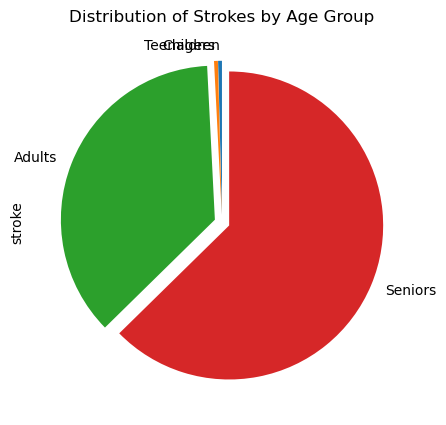

In [5]:
# Plot the pie chart

age_group_sum.plot.pie(explode= [0.05] * len(age_group_sum), startangle=90, figsize=(7, 5))
plt.title('Distribution of Strokes by Age Group')

plt.show()

In [6]:
#Stadistical analysis of all age groups
stroke_data = stroke_df[stroke_df['stroke'] == 1]

# Group the stroke data by age group
age_group_stats = stroke_data.groupby('age_group')['age'].agg(['mean', 'median', lambda x: x.mode().values[0], 'var', 'std'])

# Rename the columns for clarity
age_group_stats.columns = ['Mean', 'Median', 'Mode', 'Variance', 'STD']

# Convert to a DataFrame
age_group_stats_df = pd.DataFrame(age_group_stats).reset_index()

# Print the statistical table
print(age_group_stats_df)

   age_group       Mean  Median   Mode   Variance       STD
0   Children   1.320000    1.32   1.32        NaN       NaN
1  Teenagers  14.000000   14.00  14.00        NaN       NaN
2     Adults  55.076923   57.00  57.00  52.027350  7.212999
3    Seniors  75.878205   77.50  78.00  21.075393  4.590794


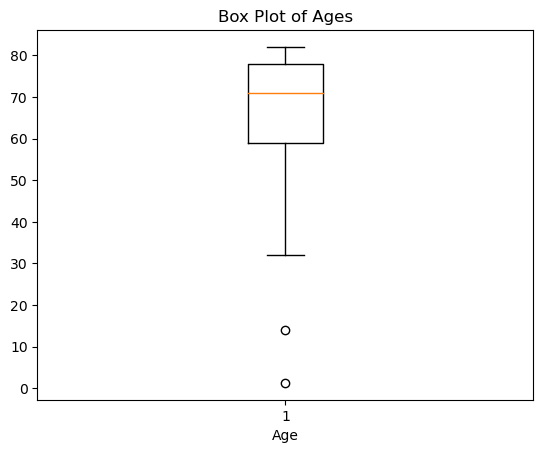

In [7]:
# Create a box plot of all ages to identify if the age groups children and teenagers could be considered outliers
plt.boxplot(stroke_data['age'])

# Set the x-axis label
plt.xlabel('Age')

# Set the title
plt.title('Box Plot of Ages')

# Display the plot
plt.show()

#### Analysis: It's a rarity and outlier to have a stroke as a child or as a teen

In [8]:
# Stadistical analysis of only Adults and seniors age groups

# Filter the DataFrame for only Adults and Seniorss
adults_df = stroke_data[stroke_data['age_group']== 'Adults']
seniors_df = stroke_data[stroke_data['age_group']== 'Seniors']

adults_seniors_df = pd.concat([adults_df, seniors_df])
adults_seniors_df

age_stats = pd.DataFrame({
    'Mean': adults_seniors_df['age'].mean(),
    'Median': adults_seniors_df['age'].median(),
    'Mode': adults_seniors_df['age'].mode().iloc[0],
    'Variance': adults_seniors_df['age'].var(),
    'Standard Deviation': adults_seniors_df['age'].std()
}, index=['Age'])

print(age_stats)


          Mean  Median  Mode   Variance  Standard Deviation
Age  68.214575    71.0  78.0  133.40499           11.550108


#### Analysis: The table above provides insight into the average age and age distribution of individuals who have experienced a stroke. It highlights that strokes can occur across a wide age range, with a tendency towards higher ages in the Adults and senior groups. 

## What is the probability to experience a stroke as we get older? 

The increase of probability to have a stroke as we get older is: 26.10%


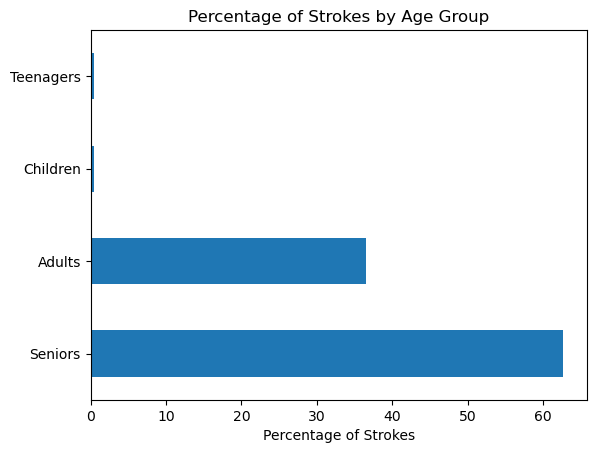

In [9]:
# Calculate the percentage of strokes for each age group
stroke_percentage = stroke_data['age_group'].value_counts(normalize=True) * 100

# Calculate the increase in probability to have a stroke as we get older
adults_probability = stroke_percentage.loc['Adults']
seniors_probability = stroke_percentage.loc['Seniors']
increase_probability = seniors_probability - adults_probability

# Print the increase in probability
print(f"The increase of probability to have a stroke as we get older is: {increase_probability:.2f}%")

# Create a horizontal bar plot
stroke_percentage.plot.barh()

plt.xlabel('Percentage of Strokes')
plt.title('Percentage of Strokes by Age Group')

plt.show()

#### Analysis: As shown, the most sensitive age group are seniors, with 60% of the test subjects had a stroke.

# Correlation between Age and Strokes

The correlation between age and the count of people with strokes is 0.68


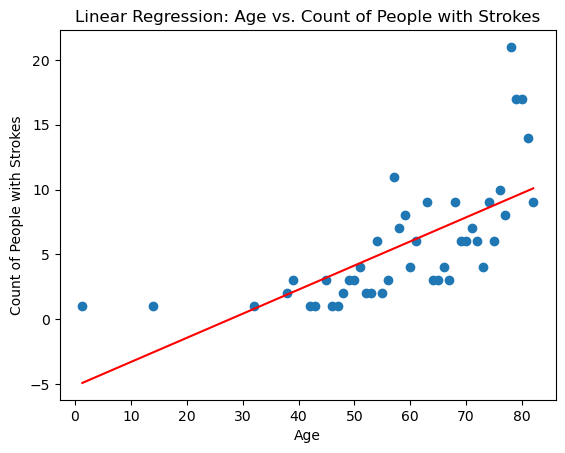

In [10]:
# Calculate the count of people for each age
age_counts = stroke_data['age'].value_counts().sort_index()

# Set the x and y values for the linear regression
x_values = age_counts.index
y_values = age_counts.values

# Perform linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the correlation between age and the count of people with strokes
correlation = round(stats.pearsonr(x_values, y_values)[0], 2)
print(f"The correlation between age and the count of people with strokes is {correlation}")

# Create the regression line
regress_values = x_values * slope + intercept

# Create the scatter plot with regression line
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.xlabel('Age')
plt.ylabel('Count of People with Strokes')
plt.title('Linear Regression: Age vs. Count of People with Strokes')
plt.show()

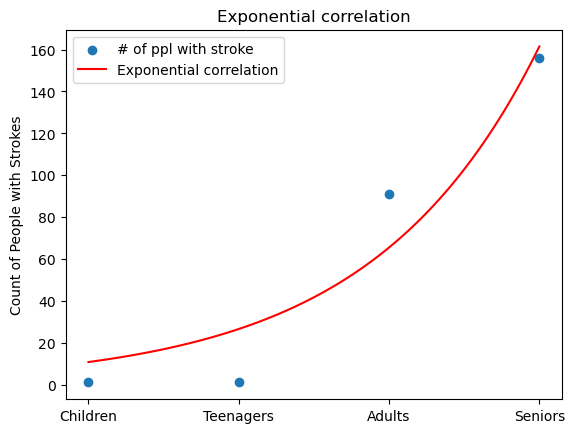

In [11]:
# Group the filtered dataframe by age group and calculate the count of strokes for each group
age_group_counts = stroke_data.groupby('age_group')['stroke'].count().reset_index()

# Extract x and y values for the plot
x_values = age_group_counts['age_group']
y_values = age_group_counts['stroke']

# Define the exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Perform the nonlinear regression
popt, pcov = curve_fit(exponential_func, range(len(x_values)), y_values)
a_opt, b_opt = popt

# Generate the fitted curve
x_fit = np.linspace(0, len(x_values)-1, 100)
y_fit = exponential_func(x_fit, a_opt, b_opt)

# Plot the original data and the fitted curve
plt.scatter(range(len(x_values)), y_values, label='# of ppl with stroke')
plt.plot(x_fit, y_fit, 'r-', label='Exponential correlation')
plt.ylabel('Count of People with Strokes')
plt.title('Exponential correlation')
plt.xticks(range(len(x_values)), x_values)
plt.legend()
plt.show()

##### Analysis: The correlation between age and stroke is 0.68. This correlation value suggests a moderately positive relationship between age and the amount of people that had a stroke. It indicates that as age increases, the likelihood of having a stroke tends to increase. However, as shown in the second correlation graph, this correlation is not linear but exponentional.